# Assignment 8 - Batch Normalization


## Library Installation (Optional)


In [1]:
# Where are you running this? Can be either 'local' or 'colab'
model_run_location = "colab"

# # Do you want to install the required packages?
# install_required_packages = False
install_required_packages = False if model_run_location == "local" else True

In [2]:
# # Install any required libraries not present in your working environment

if install_required_packages:
    # # Needed locally and in colab
    # !pip install torchsummary
    # !conda install -c frgfm torchscan

    import sys
    !{sys.executable} -m pip install torchsummary

    # # Only if you want to automate receptive field calculation
    # if model_run_location == 'colab':
    #     !{sys.executable} -m pip install torchscan
    # elif model_run_location == 'local':
    #     %conda install --yes --prefix {sys.prefix} -c frgfm torchscan

    # # Needed locally
    # !conda install -c conda-forge tqdm
    # !conda install -c anaconda ipywidgets

    if model_run_location == 'local':
        %conda install --yes --prefix {sys.prefix} -c conda-forge tqdm
        %conda install --yes --prefix {sys.prefix} -c anaconda ipywidgets


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Mount Drive


In [3]:
# Mount google drive if running on colab
if model_run_location == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')
    %cd /content/drive/MyDrive/WorkSpace/era-v1/Session 08/Submission

Mounted at /content/drive
/content/drive/MyDrive/WorkSpace/era-v1/Session 08/Submission


## Import Libraries


In [4]:
# Import necessary modules (external libs)
from __future__ import print_function

import pickle

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchsummary import summary
from torchvision import transforms

In [5]:
# Import user defined modules
from model import NormalizationModel as Net, test_model, train_model
from dataset import split_cifar_data
from utils import get_device
from visualize import (
    plot_sample_training_images,
    plot_train_test_metrics,
    plot_misclassified_images,
)

In [6]:
# Functionality to check cuda support and create device is now moved to utils.py
device_support, device = get_device()
print(f"Device created with {device_support}!")

Device created with cuda!


## Data Transformations


In [7]:
# Train and test data transformation steps now moved to apply_mnist_image_transformations()

# Use precomputed values for mean and standard deviation of the dataset
cifar_mean = (0.4915, 0.4823, 0.4468)
cifar_std = (0.2470, 0.2435, 0.2616)


def apply_cifar_image_transformations():
    """
    Function to apply the required transformations to the MNIST dataset.
    """
    # Apply the required transformations to the MNIST dataset
    train_transforms = transforms.Compose(
        [
            # Convert the images to tensors
            # normalize the images with mean and standard deviation from the whole dataset
            transforms.ToTensor(),
            transforms.Normalize(cifar_mean, cifar_std),
        ]
    )

    # Test data transformations
    test_transforms = transforms.Compose(
        # Convert the images to tensors
        # normalize the images with mean and standard deviation from the whole dataset
        [
            transforms.ToTensor(),
            transforms.Normalize(cifar_mean, cifar_std),
        ]
    )

    return train_transforms, test_transforms


train_transforms, test_transforms = apply_cifar_image_transformations()

## Train/Test Split


In [8]:
data_path = "../../data"
print(f"Train and test data path: {data_path}")

train_data, test_data = split_cifar_data(data_path, train_transforms, test_transforms)

Train and test data path: ../../data
Files already downloaded and verified
Files already downloaded and verified


## Dataloaders


In [9]:
# Set seed value for reproducibility
seed = 1

# For reproducibility
torch.manual_seed(seed)

if device_support == "cuda":
    torch.cuda.manual_seed(seed)

batch_size = 64

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(
    shuffle=True, batch_size=batch_size, num_workers=2, pin_memory=True
)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

In [10]:
# Create class labels
classes = [
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

# Convert classes to propercase
classes = tuple([c.capitalize() for c in classes])
print(classes)

('Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')


## Sample Training Images


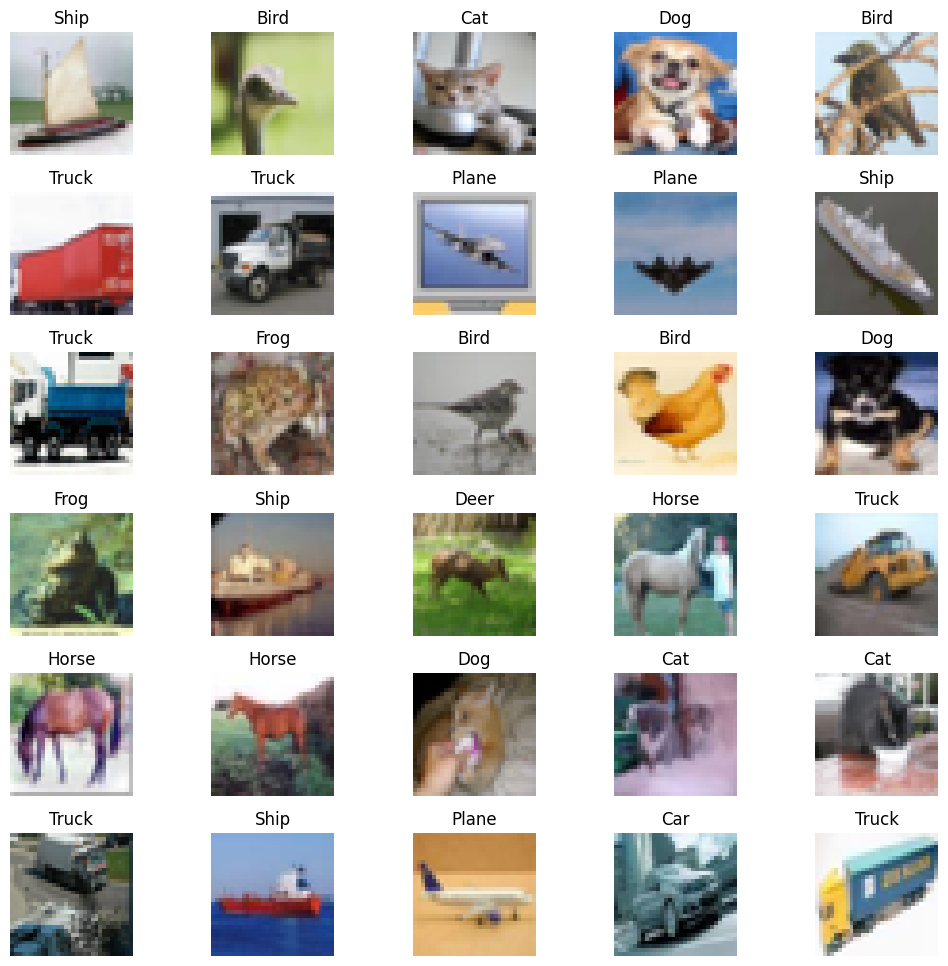

In [11]:
# Get a batch of training data from train_loader
batch_data, batch_label = next(iter(train_loader))

# Plot 30 sample images from the training data along with their labels
# plot_sample_training_images() imported from utils.py
fig, axs = plot_sample_training_images(
    batch_data, batch_label, class_label=classes, num_images=30
)
plt.show()

## Model Summary


In [12]:
# Model class is imported from model.py

# Send the model to device
model = Net(normalization_method="batch").to(device)

# enable printing shape
model.print_shape = True

# Print the model summary by specifying the input size
summary(model, input_size=(3, 32, 32))

# disable printing shape for cleaner test train output
model.print_shape = False

torch.Size([2, 12, 32, 32])
torch.Size([2, 16, 32, 32])
torch.Size([2, 8, 32, 32])
torch.Size([2, 24, 16, 16])
torch.Size([2, 24, 16, 16])
torch.Size([2, 24, 16, 16])
torch.Size([2, 24, 16, 16])
torch.Size([2, 12, 16, 16])
torch.Size([2, 12, 8, 8])
torch.Size([2, 32, 8, 8])
torch.Size([2, 32, 8, 8])
torch.Size([2, 32, 8, 8])
torch.Size([2, 32, 1, 1])
torch.Size([2, 10, 1, 1])
torch.Size([2, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 32, 32]             324
              ReLU-2           [-1, 12, 32, 32]               0
           Dropout-3           [-1, 12, 32, 32]               0
       BatchNorm2d-4           [-1, 12, 32, 32]              24
            Conv2d-5           [-1, 16, 32, 32]           1,728
              ReLU-6           [-1, 16, 32, 32]               0
           Dropout-7           [-1, 16, 32, 32]               0
       BatchNorm2d-8    

## Metric Initialisation


In [13]:
# Data to plot accuracy and loss graphs

# Hold test and train losses in a list
train_losses = []
test_losses = []
# Hold test and train accuracies in a list
train_acc = []
test_acc = []
# Create a dictionary of lists for misclassified images, generated predictions and ground truth
misclassified_image_data = {"images": [], "ground_truths": [], "predicted_vals": []}

## Train and Test


In [14]:
# Create optimizer and scheduler
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Define criteria function
criterion = F.nll_loss

# Learning rate scheduler based on plateau
# https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=1, threshold=0.03, verbose=False
)

# Specify the number of epochs
num_epochs = 20

for epoch in range(1, num_epochs + 1):
    if epoch == 1:
        print(f"\n\nBatch size: {batch_size}, Total epochs: {num_epochs}\n\n")

    # Print the current epoch
    print(f"Epoch {epoch}")
    # Train the model
    train_model(
        model, device, train_loader, optimizer, criterion, train_acc, train_losses
    )
    # Test the model
    test_model(
        model,
        device,
        test_loader,
        criterion,
        test_acc,
        test_losses,
        misclassified_image_data,
    )
    # Passing the latest test loss in list to scheduler to adjust learning rate
    scheduler.step(test_losses[-1])
    # Line break before next epoch
    print("\n")



Batch size: 64, Total epochs: 20


Epoch 1


Train: Loss=1.2491, Batch_id=781, Accuracy=43.67: 100%|██████████| 782/782 [00:23<00:00, 33.62it/s]


Test set: Average loss: 1.2658, Accuracy: 5342/10000 (53.42%)


Epoch 2


Train: Loss=0.7834, Batch_id=781, Accuracy=57.67: 100%|██████████| 782/782 [00:22<00:00, 34.14it/s]


Test set: Average loss: 1.1177, Accuracy: 5909/10000 (59.09%)


Epoch 3


Train: Loss=0.8526, Batch_id=781, Accuracy=62.65: 100%|██████████| 782/782 [00:24<00:00, 32.48it/s]


Test set: Average loss: 1.0612, Accuracy: 6196/10000 (61.96%)


Epoch 4


Train: Loss=0.9887, Batch_id=781, Accuracy=65.34: 100%|██████████| 782/782 [00:24<00:00, 32.38it/s]


Test set: Average loss: 1.0183, Accuracy: 6263/10000 (62.63%)


Epoch 5


Train: Loss=1.2589, Batch_id=781, Accuracy=67.05: 100%|██████████| 782/782 [00:23<00:00, 33.34it/s]


Test set: Average loss: 0.8845, Accuracy: 6872/10000 (68.72%)


Epoch 6


Train: Loss=0.6779, Batch_id=781, Accuracy=68.42: 100%|██████████| 782/782 [00:22<00:00, 34.74it/s]


Test set: Average loss: 0.9555, Accuracy: 6597/10000 (65.97%)


Epoch 7


Train: Loss=0.9794, Batch_id=781, Accuracy=69.77: 100%|██████████| 782/782 [00:22<00:00, 34.45it/s]


Test set: Average loss: 0.8428, Accuracy: 7029/10000 (70.29%)


Epoch 8


Train: Loss=0.4545, Batch_id=781, Accuracy=70.92: 100%|██████████| 782/782 [00:23<00:00, 33.47it/s]


Test set: Average loss: 0.7917, Accuracy: 7175/10000 (71.75%)


Epoch 9


Train: Loss=1.0865, Batch_id=781, Accuracy=71.80: 100%|██████████| 782/782 [00:23<00:00, 32.60it/s]


Test set: Average loss: 0.7960, Accuracy: 7171/10000 (71.71%)


Epoch 10


Train: Loss=1.1939, Batch_id=781, Accuracy=73.01: 100%|██████████| 782/782 [00:24<00:00, 32.42it/s]


Test set: Average loss: 0.8145, Accuracy: 7127/10000 (71.27%)


Epoch 11


Train: Loss=0.6891, Batch_id=781, Accuracy=74.94: 100%|██████████| 782/782 [00:24<00:00, 32.49it/s]


Test set: Average loss: 0.7463, Accuracy: 7313/10000 (73.13%)


Epoch 12


Train: Loss=0.7123, Batch_id=781, Accuracy=75.36: 100%|██████████| 782/782 [00:22<00:00, 34.46it/s]


Test set: Average loss: 0.7319, Accuracy: 7386/10000 (73.86%)


Epoch 13


Train: Loss=0.3623, Batch_id=781, Accuracy=75.75: 100%|██████████| 782/782 [00:22<00:00, 35.09it/s]


Test set: Average loss: 0.7134, Accuracy: 7497/10000 (74.97%)


Epoch 14


Train: Loss=1.1267, Batch_id=781, Accuracy=76.22: 100%|██████████| 782/782 [00:23<00:00, 33.81it/s]


Test set: Average loss: 0.7570, Accuracy: 7296/10000 (72.96%)


Epoch 15


Train: Loss=0.7276, Batch_id=781, Accuracy=76.61: 100%|██████████| 782/782 [00:26<00:00, 30.04it/s]


Test set: Average loss: 0.7447, Accuracy: 7407/10000 (74.07%)


Epoch 16


Train: Loss=0.7633, Batch_id=781, Accuracy=77.56: 100%|██████████| 782/782 [00:24<00:00, 32.24it/s]


Test set: Average loss: 0.6916, Accuracy: 7582/10000 (75.82%)


Epoch 17


Train: Loss=0.9143, Batch_id=781, Accuracy=77.86: 100%|██████████| 782/782 [00:23<00:00, 33.72it/s]


Test set: Average loss: 0.6884, Accuracy: 7583/10000 (75.83%)


Epoch 18


Train: Loss=0.5317, Batch_id=781, Accuracy=77.93: 100%|██████████| 782/782 [00:22<00:00, 34.60it/s]


Test set: Average loss: 0.6716, Accuracy: 7671/10000 (76.71%)


Epoch 19


Train: Loss=0.7090, Batch_id=781, Accuracy=78.69: 100%|██████████| 782/782 [00:22<00:00, 34.33it/s]


Test set: Average loss: 0.6922, Accuracy: 7523/10000 (75.23%)


Epoch 20


Train: Loss=0.8031, Batch_id=781, Accuracy=78.72: 100%|██████████| 782/782 [00:23<00:00, 33.11it/s]


Test set: Average loss: 0.6889, Accuracy: 7580/10000 (75.80%)




## Metrics


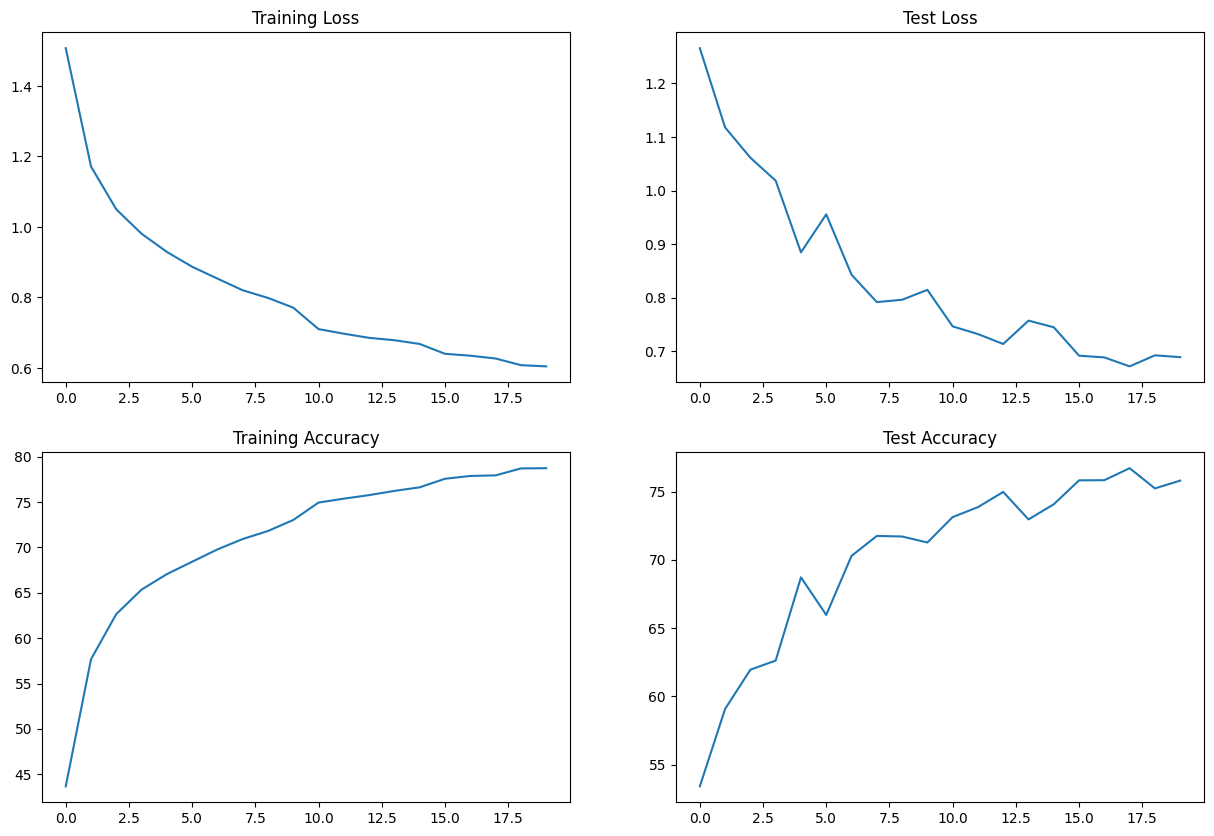

In [15]:
# Plot the accuracy and loss graphs using data and plot_train_test_metrics() from model.py
fig, axs = plot_train_test_metrics(train_losses, train_acc, test_losses, test_acc)
plt.show()

## Save model and misclassified image data

In [ ]:
# Save model
torch.save(model.state_dict(), "assignment_8_bn.pt")

# Save the misclassified images data


with open("assignment_8_bn_misclassified_images.pkl", "wb") as f:
    pickle.dump(misclassified_image_data, f)

## Show incorrect images


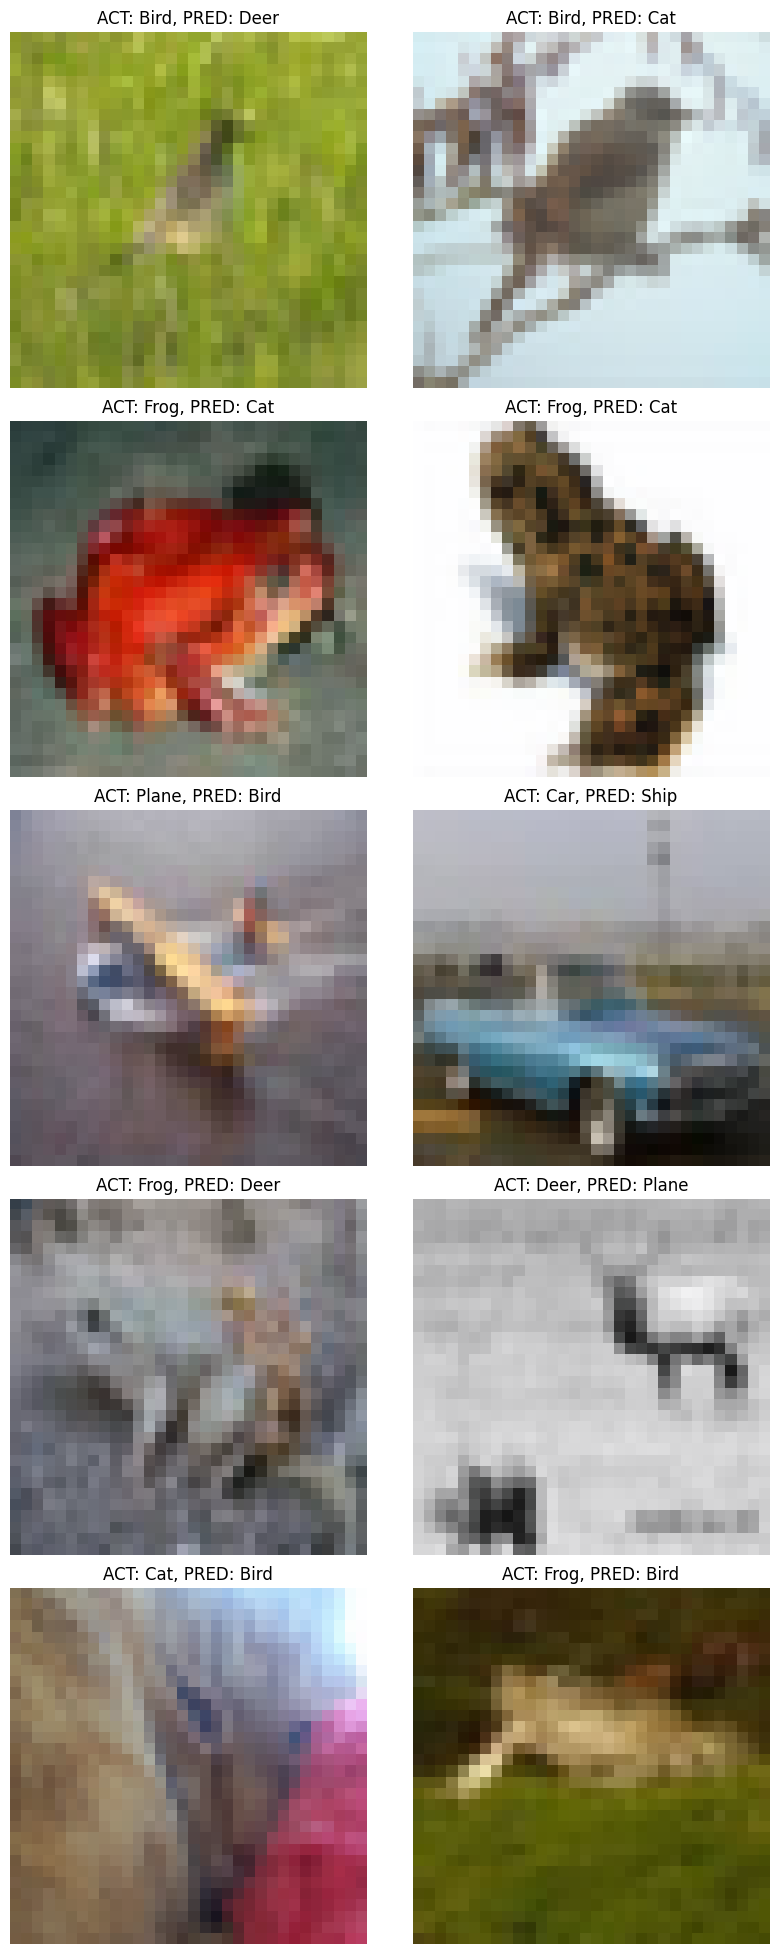

In [16]:
# Plot misclassified images
fig, axs = plot_misclassified_images(
    data=misclassified_image_data, class_label=classes, num_images=10
)
plt.show()